In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import time
from datasketch import MinHash, MinHashLSH
import matplotlib.pyplot as plt
from scipy import vstack
import random



In [2]:
#load datasets
data = pd.read_csv("C:/Users/Professional/BigDataAnalytics/imdb/processed_data.csv")
test = pd.read_csv("C:/Users/Professional/BigDataAnalytics/imdb/processed_test.csv")

# Brute Force Jaccard


$\bf{Modeling}$

In [3]:
train_feat_c = data["review"].tolist()
train_lab = data["sentiment"].tolist()
test_feat_c = test["review"].tolist()

In [4]:
vectorizer = CountVectorizer(binary=True)

train_feat = vectorizer.fit_transform(train_feat_c)
test_feat = vectorizer.transform(test_feat_c)

In [5]:
def custom_jaccard1(vec1,vec2):
    denominator = (vec1+vec2).count_nonzero()
    numerator =  vec1.count_nonzero()+vec2.count_nonzero() - denominator
    return 1- numerator/denominator

In [6]:
neighbf = KNeighborsClassifier(n_neighbors=15, algorithm='brute' ,metric=custom_jaccard1)
neighbf.fit(train_feat,train_lab )

KNeighborsClassifier(algorithm='brute',
                     metric=<function custom_jaccard1 at 0x000001EBCB54EE50>,
                     n_neighbors=15)

In [7]:
start=time.time()
BFjaccard=neighbf.kneighbors(test_feat[9], return_distance=False)
end=time.time()
print(end-start)

9.149529933929443


In [8]:
start=time.time()
print(custom_jaccard1(train_feat[6],train_feat[7]))
end=time.time()
print(end-start)

0.9414414414414415
0.0019941329956054688


# LSH


In [9]:
train_feat_c_set=[]
for i in range(len(train_feat_c)):
    train_feat_c_set.append(set(train_feat_c[i].split()))

In [10]:
test_feat_c_set=[]
for i in range(len(test_feat_c)):
    test_feat_c_set.append(set(test_feat_c[i].split()))

In [11]:
def vector_hashing(doc, num_perm):
    m = MinHash(num_perm=num_perm)
    for word in doc:
        m.update(word.encode('utf8'))
    return m

In [22]:
def lsh_build_index(docs, num_perm, sim_thresh=0.6):
    lsh_index = MinHashLSH(sim_thresh, num_perm=num_perm)
    for i in range(len(docs)):
        hashed_doc = vector_hashing(docs[i], num_perm)
        lsh_index.insert(i, hashed_doc)
    return lsh_index

In [13]:
def bucket_creation(query_doc, lsh_build_index, num_perm):
    hashed_query_doc = vector_hashing(query_doc, num_perm)
    bucket = lsh_build_index.query(hashed_query_doc)
    return bucket

In [14]:
def lsh_knn_fit(train_feat_c,train_lab,vectorizer,bucket_ind):
    bucket_train=[]
    bucket_lab=[]
    for ind in bucket_ind:
        bucket_train.append(train_feat_c[ind])
        bucket_lab.append(train_lab[ind])
    bucket_train=vectorizer.transform(bucket_train)
    n_n =  KNeighborsClassifier(n_neighbors=15, algorithm='brute', metric=custom_jaccard1).fit(bucket_train,bucket_lab)
    return n_n

In [15]:
def BFquering(query_ind,test_feat,neighbf):
    BF_15=[]
    for i in query_ind:
        BFjaccard=neighbf.kneighbors(test_feat[i], return_distance=False)
        BFjaccard=BFjaccard.tolist()
        BFjaccard=BFjaccard[0]
        BF_15.append(BFjaccard)
    return BF_15
    

In [16]:
def matches_list(top_list,BFcos):
    matches=[]
    for i in range(len(top_list)):
        m=common(top_list[i],BFcos[i])
        matches.append(m)
    return matches


In [17]:
def common(vec1,vec2):
    x=0
    for i in range(len(vec1)):
        if vec1[i] in vec2:
                x+=1
    return x 

In [18]:
def quering(query_ind,train_feat_c,train_lab,test_feat_c_set,lsh_build_index,vectorizer, num_perm):
    top_15=[]
    for i in query_ind:
        bucket=bucket_creation(test_feat_c_set[i],lsh_build_index, num_perm)
        if len(bucket)<15:
            temp=bucket[:]
        else:
            n_n=lsh_knn_fit(train_feat_c,train_lab,vectorizer,bucket)
            n=n_n.kneighbors(test_feat[i], return_distance=False)
            n=n.tolist()
            n=n[0]
            temp=[]
            for i in range(len(n)):
                ind=bucket[n[i]]
                temp.append(ind)
        top_15.append(temp)
    return top_15

In [23]:
K=[16,32,64]
BuildTime = []
QueryTime = []
TotalTime = []
AvgPerc = []
#query_ind = random.sample(range(10000), 1000)
query_ind = list(range(10000))
for k in K:
    #LSH Index Creation Time
    start=time.time()
    lsh_ind = lsh_build_index(train_feat_c_set,k)    
    end=time.time()
    b=end-start
    BuildTime.append(b)
    
    
    #QueryTime
    start=time.time()
    top_15=quering(query_ind,train_feat_c,train_lab,test_feat_c_set,lsh_ind,vectorizer,k)
    end=time.time()
    q=end-start
    QueryTime.append(q)
    t=b+q
    TotalTime.append(t)
    BFjac=BFquering(query_ind,test_feat,neighbf)
    matches=matches_list(top_15,BFjac)
    perc = ((sum(matches)/15)/10)*100
    AvgPerc.append(perc)
  

In [24]:
print(AvgPerc)
print(BuildTime)
print(QueryTime)
print(TotalTime)

[0.6666666666666666, 0.6666666666666666, 0.6666666666666666]
[53.595641136169434, 56.40787672996521, 67.35669350624084]
[0.009975433349609375, 0.012966632843017578, 0.013967037200927734]
[53.60561656951904, 56.42084336280823, 67.37066054344177]


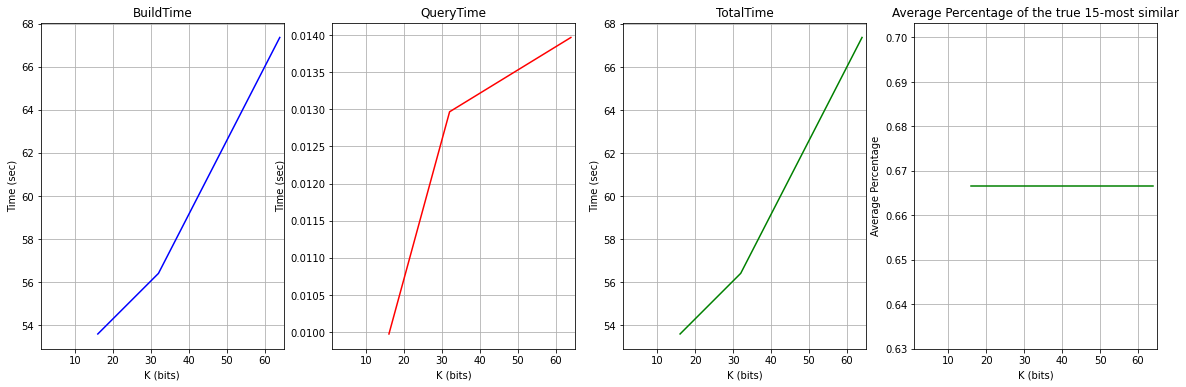

<Figure size 432x288 with 0 Axes>

In [25]:
fig = plt.figure(figsize=(20, 6))

plt.subplot(1,4,1)
plt.plot(K, BuildTime, color='b')
plt.xlim(1,K[-1]+1)
plt.grid(True)
plt.xlabel('K (bits)')
plt.ylabel('Time (sec)')
plt.title("BuildTime")

plt.subplot(1,4,2)
plt.plot(K, QueryTime, color='r')
plt.xlim(1,K[-1]+1)
plt.grid(True)
plt.xlabel('K (bits)')
plt.ylabel('Time (sec)')
plt.title("QueryTime")

plt.subplot(1,4,3)
plt.plot(K, TotalTime, color='g')
plt.xlim(1,K[-1]+1)
plt.grid(True)
plt.xlabel('K (bits)')
plt.ylabel('Time (sec)')
plt.title("TotalTime")

plt.subplot(1,4,4)
plt.plot(K, AvgPerc, color='g')
plt.xlim(1,K[-1]+1)
plt.grid(True)
plt.xlabel('K (bits)')
plt.ylabel('Average Percentage')
plt.title("Average Percentage of the true 15-most similar")

plt.show()
plt.savefig('Jaccard')